# 시뮬레이션 데이터 생성 코드

In [52]:
   """
    전처리가 필요한 원본 A/B 테스트 데이터를 생성합니다.
    - 정확한 트래픽 비율(기본 50:50)과 재현성(seed)을 지원
    - 비구매(0)와 결제중 이탈(NaN)을 구분하고, 보조 플래그 컬럼 제공
    - 타임스탬프 기준 시간(now) 외부 주입 가능
    """
#import
import pandas as pd
import numpy as np
import datetime as dt

# 🚩 변수 초기화
#session, 트래픽 비율, seed 초기화
def generate_raw_data(
    num_sessions: int = 100000,
    traffic_ratio=(0.5, 0.5),
    seed: int | None = 42,
    now: dt.datetime | None = None,
):

    # 난수생성 및 시간 설정
    rng = np.random.default_rng(seed)
    if now is None:
        now = dt.datetime.now()

    # 그룹별 행동 확률/파라미터
    """
    A - 현재 추석선물에 큐레이션 유지 그룹 ("컬리온리","실용만점" 등)
    B - ( # 평소 감사한 분들께 , # 부모님께) 등과 같은 큐레이션을 넣은 그룹
    """
    params = {
        'A': {'click_proba': 0.15, 'buy_proba': 0.025, 'bounce_proba': 0.35, 'aov': 68000},
        'B': {'click_proba': 0.25, 'buy_proba': 0.031, 'bounce_proba': 0.29, 'aov': 71500}
    }

    # 정확한 트래픽 비율로 그룹 리스트 생성 후 셔플
    nA = int(num_sessions * traffic_ratio[0])
    nB = num_sessions - nA
    groups = np.array(['A'] * nA + ['B'] * nB)
    rng.shuffle(groups)

    # 최근 2주 각 사용자의 접속시간 접속기기 데이터 생성
    max_minutes = 14 * 24 * 60
    minute_offsets = rng.integers(0, max_minutes, size=num_sessions)
    timestamps = np.array([now - dt.timedelta(minutes=int(m)) for m in minute_offsets])

    devices = rng.choice(['mobile', 'desktop'], size=num_sessions, p=[0.8, 0.2])

    # 결과 컨테이너
    session_ids = [f'session_{i}' for i in range(num_sessions)]
    page_views = np.empty(num_sessions, dtype=int)
    clicked_curation = np.zeros(num_sessions, dtype=int)
    purchase_amount = np.zeros(num_sessions, dtype=float)
    purchased_flag = np.zeros(num_sessions, dtype=int)
    abandoned_at_payment = np.zeros(num_sessions, dtype=int)

    # 🚩 데이터 생성
    for i in range(num_sessions):
        g = groups[i]
        p = params[g]

        # 이탈 여부
        is_bounce = rng.random() < p['bounce_proba']
        if is_bounce:
            page_views[i] = 1
            clicked_curation[i] = 0
            # purchase_amount[i] already 0.0
            continue

        # 비이탈 세션: 페이지뷰 랜덤(2~9)
        page_views[i] = rng.integers(2, 10)

        # 클릭
        clicked_curation[i] = 1 if rng.random() < p['click_proba'] else 0

        # 구매
        if rng.random() < p['buy_proba']:
            # 결제 중 이탈(결측)
            if rng.random() < 0.1:
                purchase_amount[i] = np.nan
                abandoned_at_payment[i] = 1
            else:
                amt = rng.normal(loc=p['aov'], scale=15000)
                amt = max(10_000, amt)
                purchase_amount[i] = round(amt)  # 원 단위 정수
                purchased_flag[i] = 1
        # else: remain 0.0

    df = pd.DataFrame({
        'session_id': session_ids,
        'timestamp': timestamps,
        'user_group': groups,
        'device': devices,
        'page_views': page_views,
        'clicked_curation': clicked_curation,
        'purchase_amount': purchase_amount,  # 0=비구매, NaN=결제중 이탈, >0=구매성공
        'purchased_flag': purchased_flag,    # 명시적 구매 성공 여부
        'abandoned_at_payment': abandoned_at_payment,  # 결제 단계 이탈(결측 발생)
    })

    return df

# 🚩노이즈 데이터 넣기
def generate_noisy_data(num_sessions=100000, seed=42, now=None):
    rng = np.random.default_rng(seed)
    if now is None:
        now = dt.datetime.now()

    # 정상 데이터 먼저 생성
    df = generate_raw_data(num_sessions=num_sessions, seed=seed, now=now)

    # 1) 중복 세션 추가 (5% 복제)
    dup = df.sample(frac=0.05, random_state=seed)
    df = pd.concat([df, dup], ignore_index=True)

    # 2) device 오타 추가 (랜덤 1%)
    idx_device = df.sample(frac=0.1, random_state=seed).index
    df.loc[idx_device, "device"] = rng.choice(["moblie", "deskotp"], size=len(idx_device))

    # 3) 구매금액 이상치 추가 (랜덤 0.5%)
    idx_amt = df.sample(frac=0.005, random_state=seed).index
    df.loc[idx_amt, "purchase_amount"] = rng.choice([-5000, 1e7, 2e7], size=len(idx_amt))

    # 4) 미래 timestamp 추가 (랜덤 0.2%)
    idx_time = df.sample(frac=0.002, random_state=seed).index
    df.loc[idx_time, "timestamp"] = now + pd.to_timedelta(rng.integers(1, 48, len(idx_time)), unit="h")

    # 5) 클릭 여부 NaN 처리 (랜덤 1%)
    idx_click = df.sample(frac=0.01, random_state=seed).index
    df.loc[idx_click, "clicked_curation"] = np.nan

    return df

# 실행 예시
df_noisy = generate_noisy_data()
df_noisy.to_csv("curation_ab_test_noisy.csv", index=False)
df_noisy

,session_id,timestamp,user_group,device,page_views,clicked_curation,purchase_amount,purchased_flag,abandoned_at_payment
0,session_0,2025-09-17 03:31:37.864930,A,desktop,1,0.0,0.0,0,0
1,session_1,2025-09-21 20:00:37.864930,A,desktop,1,0.0,0.0,0,0
2,session_2,2025-09-20 15:09:37.864930,A,mobile,1,0.0,0.0,0,0
3,session_3,2025-09-24 20:44:37.864930,B,mobile,5,0.0,0.0,0,0
4,session_4,2025-09-17 13:42:37.864930,B,mobile,3,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...
104995,session_44719,2025-09-15 21:13:37.864930,B,mobile,4,0.0,0.0,0,0
104996,session_20980,2025-09-14 13:05:37.864930,B,mobile,4,0.0,54761.0,1,0
104997,session_57224,2025-09-22 04:25:37.864930,A,deskotp,3,0.0,64691.0,1,0
104998,session_23910,2025-09-25 11:48:37.864930,A,mobile,1,0.0,0.0,0,0


# **노이즈 제거 및 시각화**

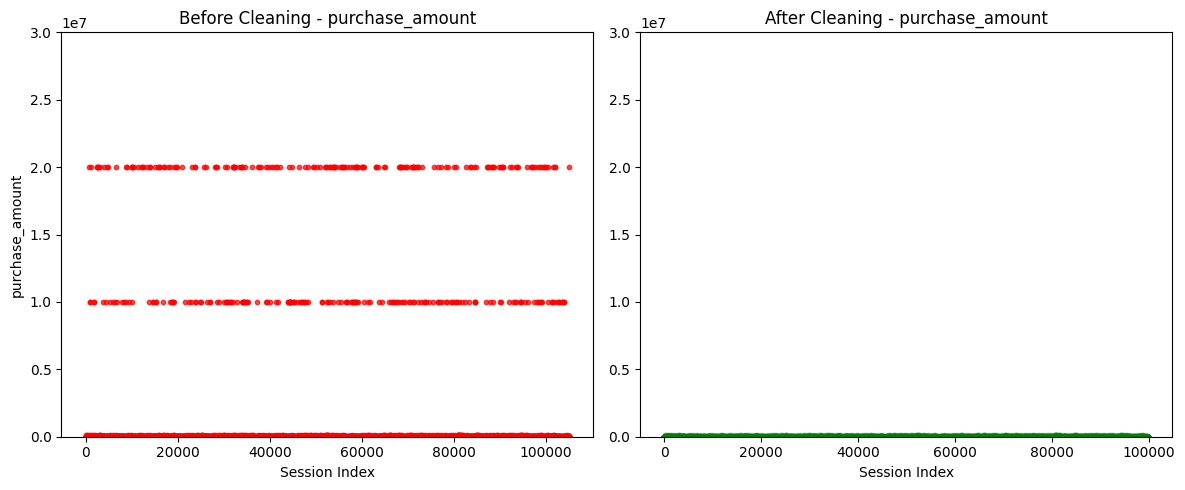

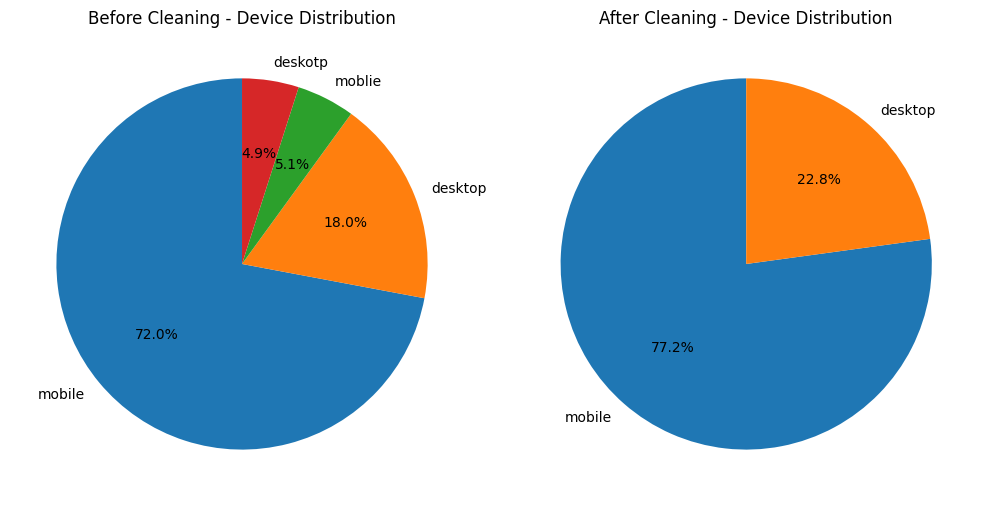

Rows Before Cleaning: 105000
Rows After Cleaning : 99797


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


# --------------------------
# 1) 원본 (노이즈 포함) 데이터 로드
df_noisy = pd.read_csv("curation_ab_test_noisy.csv")

# 2) 전처리 적용
df_clean = df_noisy.copy()

# 중복 제거
df_clean = df_clean.drop_duplicates(subset=["session_id"], keep="first")

# device 정규화
df_clean['device'] = df_clean['device'].replace({"moblie": "mobile", "deskotp": "desktop"})

# 구매금액 이상치 처리 (0보다 작거나 100만 원 이상 값 제거)
df_clean.loc[(df_clean['purchase_amount'] < 0) | (df_clean['purchase_amount'] > 1000000), 'purchase_amount'] = np.nan

# timestamp 변환 + 미래값 제거
now = dt.datetime.now()
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], errors='coerce')
df_clean = df_clean[df_clean['timestamp'] <= now]

# 클릭 NaN 처리
df_clean['clicked_curation'] = df_clean['clicked_curation'].fillna(0)
# --------------------------

plt.figure(figsize=(12,5))

# Before
plt.subplot(1,2,1)
plt.scatter(range(len(df_noisy)), df_noisy['purchase_amount'], alpha=0.7, color="red", s=10)
plt.ylim(0, 3e7)
plt.title("Before Cleaning - purchase_amount")
plt.xlabel("Session Index")
plt.ylabel("purchase_amount")

# After
plt.subplot(1,2,2)
plt.scatter(range(len(df_clean)), df_clean['purchase_amount'], alpha=0.3, color="green", s=10)
plt.ylim(0, 3e7)
plt.title("After Cleaning - purchase_amount")
plt.xlabel("Session Index")

plt.tight_layout()
plt.show()


# ==========================
# 📊 2. Device 비율 (Before vs After)
# ==========================
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

device_before = df_noisy['device'].value_counts()
device_after = df_clean['device'].value_counts()

axes[0].pie(device_before, labels=device_before.index, autopct="%1.1f%%", startangle=90)
axes[0].set_title("Before Cleaning - Device Distribution")

axes[1].pie(device_after, labels=device_after.index, autopct="%1.1f%%", startangle=90)
axes[1].set_title("After Cleaning - Device Distribution")

plt.tight_layout()
plt.show()

# ==========================
# 📉 3. 데이터 개수 비교
# ==========================
print("Rows Before Cleaning:", len(df_noisy))
print("Rows After Cleaning :", len(df_clean))


In [54]:
import pandas as pd
import numpy as np

# 1) 로드
try:
    df = pd.read_csv('curation_ab_test_noisy.csv')

except FileNotFoundError:
    raise SystemExit("Error: 'raw_ab_test_data.csv' 파일을 찾을 수 없습니다. 먼저 데이터 생성 코드를 실행해주세요.")

print("\n====== 1. 데이터 전처리 과정 ======")
print("\n[초기 데이터 정보]")
df.info()

# 🚩 (노이즈) 데이터 정제
# 중복 세션 제거
df = df.drop_duplicates(subset=["session_id"], keep="first")

# device 오타 정규화
df['device'] = df['device'].replace({"moblie": "mobile", "deskotp": "desktop"})

# purchase_amount 이상치 제거
# (0보다 작거나 백만원 이상인 값은 이상치로 간주 → NaN 처리)
df.loc[(df['purchase_amount'] < 0) | (df['purchase_amount'] > 1_000_000), 'purchase_amount'] = np.nan


#  미래 timestamp 제거
now = dt.datetime.now()
df = df[df['timestamp'] <= str(now)]

# clicked_curation NaN → 0 처리
df['clicked_curation'] = df['clicked_curation'].fillna(0)

# 2)🚩 전처리
# timestamp: 필요 시 utc=True 고려
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# 금액 컬럼을 수치로 강제(혹시 문자열로 저장된 경우 대비)
df['purchase_amount'] = pd.to_numeric(df['purchase_amount'], errors='coerce')

# (중요) 결제 단계 이탈 플래그 먼저 생성 (NaN 보존)
df['abandoned_at_payment'] = df['purchase_amount'].isna()

# 구매 성공 플래그: NaN(결제이탈)은 False, 금액>0인 경우만 True
df['converted'] = (df['purchase_amount'].fillna(0) > 0)

# 보고/집계용: 금액 NaN은 0으로 채움(비구매/이탈 구분은 위 플래그로 유지)
df['purchase_amount_filled'] = df['purchase_amount'].fillna(0)

# 🚩유틸
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

def format_pct(x):
    return f"{x*100:.2f}%"

def holm_bonferroni(pvals, alpha=0.05):
    # 반환: 보정 후 유의(각 지표별 True/False)
    m = len(pvals)
    order = np.argsort(pvals)
    passed = [False]*m
    for k, idx in enumerate(order, start=1):
        if pvals[idx] <= alpha/(m-k+1):
            passed[idx] = True
        else:
            # 이후는 모두 False
            break
    return passed

# 🚩지표 계산 준비

df['exposed'] = 1  # 노출된 모든 세션
df['clicked'] = (df['clicked_curation'] == 1).astype(int)  # 큐레이션 클릭 여부 → CTR 계산용.
df['purchased'] = df['converted'].astype(int)  #구매 전환 여부 → CVR 계산용
df['revenue'] = df['purchase_amount_filled']  # NaN->0 처리된 금액
df['bounced'] = (df['page_views'] == 1).astype(int)

# 결제단계 이탈: 가능하면 별도 이벤트 기반 권장. 현재 데이터 기준:
df['abandon_pay'] = df['abandoned_at_payment'].astype(int) if 'abandoned_at_payment' in df.columns else 0

def agg(group):
    n = len(group)
    return pd.Series({
        'sessions': n,
        'ctr': group['clicked'].sum()/n if n else 0.0,
        'cvr': group['purchased'].sum()/n if n else 0.0,
        'bounce': group['bounced'].sum()/n if n else 0.0,
        'abandon_pay': group['abandon_pay'].sum()/n if n else 0.0,
        'aov': group.loc[group['purchased']==1, 'revenue'].mean() if group['purchased'].sum()>0 else 0.0,
        'rps': group['revenue'].sum()/n if n else 0.0,
        'clicks': group['clicked'].sum(),
        'purchases': group['purchased'].sum(),
        'revenue_sum': group['revenue'].sum()
    })

by = df.groupby('user_group').apply(agg)
A, B = by.loc['A'], by.loc['B']


def prop_report(success_A, n_A, success_B, n_B, metric_name):
    # A/B 그룹의 비율 차이가 통계적으로 유의미한지 확인
    stat, p = proportions_ztest([success_A, success_B], [n_A, n_B], alternative='two-sided')

    # Newcombe/Wilson CI (각 그룹) _ 성공률에 대한 신뢰구간을 계산
    ci_A = proportion_confint(success_A, n_A, method='wilson')
    ci_B = proportion_confint(success_B, n_B, method='wilson')

    #절대 리프트와 상대 리프트 계산
    lift_abs = (success_B/n_B) - (success_A/n_A)
    lift_rel = lift_abs / (success_A/n_A) if success_A>0 else np.nan
    return {
        'metric': metric_name,
        'A': success_A/n_A, 'A_CI_low': ci_A[0], 'A_CI_high': ci_A[1],
        'B': success_B/n_B, 'B_CI_low': ci_B[0], 'B_CI_high': ci_B[1],
        'diff(B-A)': lift_abs, 'rel_lift': lift_rel, 'p_value': p
    }
    """
    1) proportions_ztest) 하는 이유
    A/B 테스트를 통해 두 그룹이 차이가 나는지 확인하려면, 단순히 숫자를 비교하는 것만으로는 부족
    진짜 효과 때문인지, 단순 우연(샘플링 변동) 때문인지를 알 수 있어야 함.

    2) proportion_confint) 계산하는 이유
    p-value는 차이가 있는지 여부만 알려주고, 얼마나 차이가 나는지 알려주지 않음
    따라서 실제 성공률이 어느 범위 안에 있을 가능성이 높은지 확인
    예 - CTR 6% ± 1% → 실제 CTR은 5~7% 사이일 가능성이 높음
    + wilson 방법으로 안정적인 신뢰구간 사용 -> 샘플이 작거나 극단값이 있어도 범위 계산의 유리

    3) 리프트 계산 이유
       절대 리프트 - 단순히 B - A 차이를 계산한 값
       상대 리프트 - A 대비 B가 얼마나 비율상 증가했는지 확인
     """

# 비율 지표 🚩 A/B테스트
rep_ctr = prop_report(int(A['clicks']), int(A['sessions']),
                      int(B['clicks']), int(B['sessions']), 'CTR')

rep_cvr = prop_report(int(A['purchases']), int(A['sessions']),
                      int(B['purchases']), int(B['sessions']), 'CVR')

rep_bounce = prop_report(int(A['bounce']*A['sessions']), int(A['sessions']),
                         int(B['bounce']*B['sessions']), int(B['sessions']), 'Bounce')

rep_abandon = prop_report(int(A['abandon_pay']*A['sessions']), int(A['sessions']),
                          int(B['abandon_pay']*B['sessions']), int(B['sessions']), 'Payment Abandon')


print(rep_ctr)


====== 1. 데이터 전처리 과정 ======

[초기 데이터 정보]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   session_id            105000 non-null  object 
 1   timestamp             105000 non-null  object 
 2   user_group            105000 non-null  object 
 3   device                105000 non-null  object 
 4   page_views            105000 non-null  int64  
 5   clicked_curation      103950 non-null  float64
 6   purchase_amount       104802 non-null  float64
 7   purchased_flag        105000 non-null  int64  
 8   abandoned_at_payment  105000 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 7.2+ MB
{'metric': 'CTR', 'A': 0.09851900839696186, 'A_CI_low': 0.09593501988675979, 'A_CI_high': 0.10116480792439056, 'B': 0.17601907892099883, 'B_CI_low': 0.17270252763610036, 'B_CI_high': 0.17938551050412407, 'diff(B-A)

/tmp/ipython-input-3845223687.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by = df.groupby('user_group').apply(agg)


# 1) 신뢰구간 (Confidence Interval)

A_CI_low, A_CI_high: 0.0893 ~ 0.1057

A그룹의 실제 CTR이 95% 확률로 이 범위 안에 있음

B_CI_low, B_CI_high: 0.1643 ~ 0.1854

B그룹의 실제 CTR이 95% 확률로 이 범위 안에 있음

즉, B그룹 CTR이 A그룹 범위를 완전히 벗어나므로, 단순 수치만 봐도 차이가 크다는 걸 시사합니다.


# 2) 절대 리프트 (diff(B-A))

diff(B-A): 0.0774 → 7.74%p 상승

실제 클릭률이 약 8%p 더 높아졌다는 뜻

KPI 기준으로 보면 A/B 중 B안이 명확히 클릭을 더 유도함

# 3) 상대 리프트 (rel_lift)

rel_lift: 0.7963 → 79.6% 상승

A 대비 B가 약 80% 더 클릭됐다는 상대적 효과

비율은 낮아도, 상대적 개선 효과가 큰 지표를 확인할 때 중요

# 4) 통계적 유의성 (p_value)

p_value ≈ 1.42e-29 (거의 0)

0.05보다 훨씬 작음 → 두 그룹의 CTR 차이는 통계적으로 유의미

“B안이 더 클릭을 잘 유도한다”라고 확신할 수 있음

# 결과해석
B안 클릭률이 확실히 높음 → 디자인/문구/큐레이션 방식 개선 효과가 큼

절대 리프트: 7.7%p → KPI 수치로 보고 “세션당 클릭 수 증가량” 계산 가능

상대 리프트: 79.6% → A안 대비 개선 폭이 크다는 것을 상대적 지표로 보여주기 좋음

신뢰구간 겹치지 않음 → 안정적인 효과

p-value 극히 작음 → 통계적으로 “우연 아님” 확신 가능

# **비율 지표 테스트 -시각화**

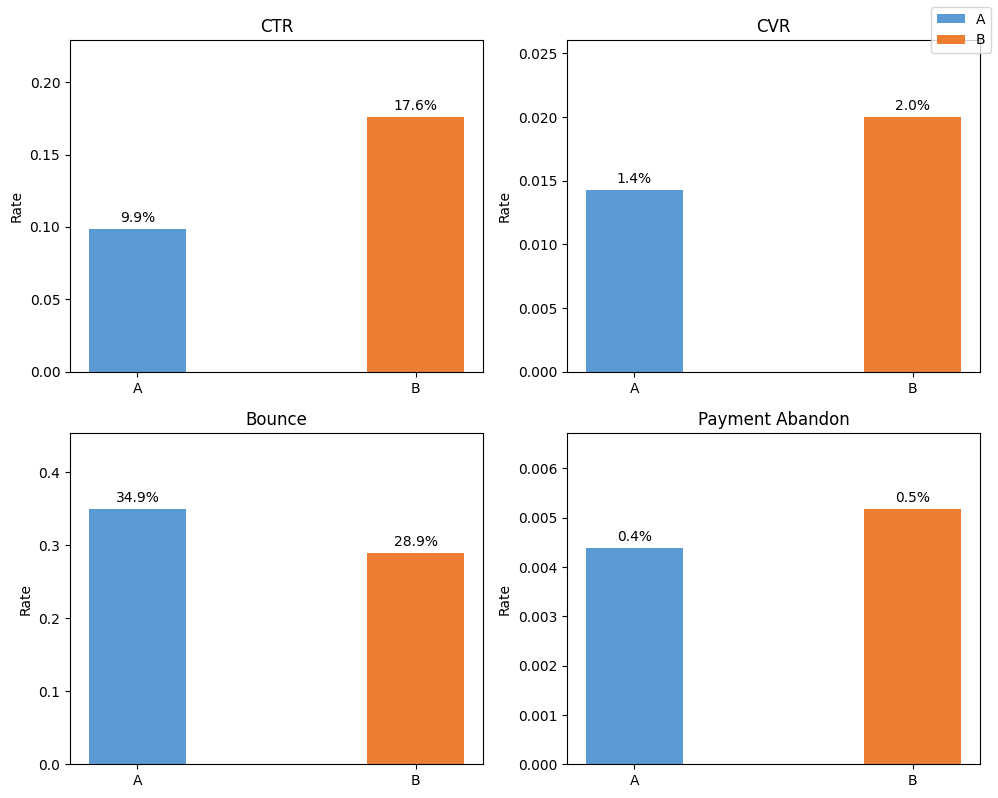

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# 🚩 데이터를 한 곳에 모음
metrics = [rep_ctr, rep_cvr, rep_bounce, rep_abandon]
metric_names = [m['metric'] for m in metrics]

A_values = [m['A'] for m in metrics]
B_values = [m['B'] for m in metrics]

x = np.arange(2)  # A, B 두 그룹
width = 0.35

# 🚩 subplot 4개 (2행 2열)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    A_val, B_val = A_values[i], B_values[i]
    metric = metric_names[i]

    rects1 = ax.bar(x[0], A_val, width, label='A', color='#5B9BD5')
    rects2 = ax.bar(x[1], B_val, width, label='B', color='#ED7D31')

    ax.set_title(metric)
    ax.set_ylabel("Rate")
    ax.set_xticks(x)
    ax.set_xticklabels(["A", "B"])
    ax.set_ylim(0, max(A_val, B_val) * 1.3)

    # 값 표시
    for rect in [rects1, rects2]:
        height = rect[0].get_height()
        ax.annotate(f"{height:.1%}",
                    xy=(rect[0].get_x() + rect[0].get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center", va="bottom")

# 공통 범례 (오른쪽 위)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.tight_layout()
plt.show()


# **비율 지표 테스트 _ 시각화_총정리**

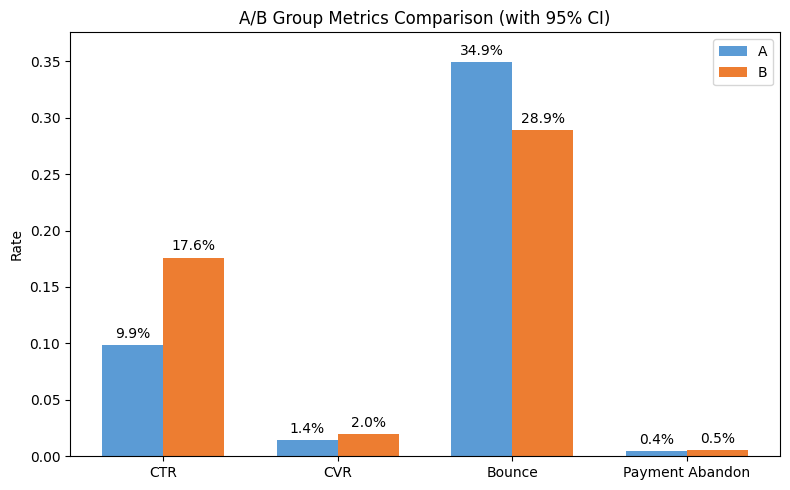

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# 🚩 데이터를 한 곳에 모음
metrics = [rep_ctr, rep_cvr, rep_bounce, rep_abandon]
metric_names = [m['metric'] for m in metrics]

A_values = [m['A'] for m in metrics]
B_values = [m['B'] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

# 🚩 그래프 그리기
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, A_values, width, capsize=5, label='A', color='#5B9BD5')
rects2 = ax.bar(x + width/2, B_values, width, capsize=5, label='B', color='#ED7D31')

# 🚩 레이블 및 제목
ax.set_ylabel('Rate')  # 비율 → Rate
ax.set_title('A/B Group Metrics Comparison (with 95% CI)')  # 제목 영어

ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()
ax.set_ylim(0, max(B_values)*1.3)  # 여유 공간

# 🚩 값 표시
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1%}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),  # 위쪽으로 3pt 이동
                    textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


# **P-value 결론**
# **CTR(클릭률), CVR(구매전환율), Bounce(이탈률)는 p < 0.001 → 매우 유의미**

# **Payment Abandon(결제 단계 이탈률)은 p = 0.0734 → 유의수준 0.05에서는 기각 불가(차이가 없다)**

In [57]:
import pandas as pd

# 🚩 결과 dict들을 모음
results = [rep_ctr, rep_cvr, rep_bounce, rep_abandon]

# 🚩 DataFrame 변환 & 열 순서 정리
df_results = pd.DataFrame(results)[[
    "metric", "A", "A_CI_low", "A_CI_high",
    "B", "B_CI_low", "B_CI_high",
    "diff(B-A)", "rel_lift", "p_value"
]]

# 🚩 포맷팅 함수
def fmt_pct(x, digits=2):
    return f"{x:.{digits}%}"

def fmt_p(x):
    # 아주 작은 값은 p<0.001 로 표시
    return "p<0.001" if x < 0.001 else f"{x:.4f}"

# 🚩 표시용 DataFrame 생성
df_display = df_results.copy()
for col in ["A", "A_CI_low", "A_CI_high", "B", "B_CI_low", "B_CI_high", "diff(B-A)", "rel_lift"]:
    df_display[col] = df_display[col].apply(fmt_pct)

df_display["p_value"] = df_results["p_value"].apply(fmt_p)

print(df_display.to_string(index=False))


         metric      A A_CI_low A_CI_high      B B_CI_low B_CI_high diff(B-A) rel_lift p_value
            CTR  9.85%    9.59%    10.12% 17.60%   17.27%    17.94%     7.75%   78.67% p<0.001
            CVR  1.43%    1.33%     1.53%  2.00%    1.88%     2.13%     0.58%   40.31% p<0.001
         Bounce 34.91%   34.49%    35.33% 28.89%   28.50%    29.29%    -6.01%  -17.22% p<0.001
Payment Abandon  0.44%    0.38%     0.50%  0.52%    0.46%     0.58%     0.08%   17.81%  0.0734


# **연속형 지표(AOV,RPS)를 A/B테스트**

In [58]:
rng = np.random.default_rng(2025)

#연속형 지표(AOV, RPS)의 신뢰구간 계산

#데이터가 정규분포가 아닐 가능성이 있으므로, 부트스트랩 방식 사용

def bootstrap_mean_ci(x, B=5000, alpha=0.05):
    x = np.asarray(x)
    boots = [rng.choice(x, size=len(x), replace=True).mean() for _ in range(B)]
    lo, hi = np.quantile(boots, [alpha/2, 1-alpha/2])
    return lo, hi


# 🚩AOV (구매자만)
aov_A = df[(df['user_group']=='A') & (df['purchased']==1)]['revenue'].values
aov_B = df[(df['user_group']=='B') & (df['purchased']==1)]['revenue'].values
t_aov, p_aov = stats.ttest_ind(aov_B, aov_A, equal_var=False) if len(aov_A)>1 and len(aov_B)>1 else (np.nan, np.nan)
aov_ci_A = bootstrap_mean_ci(aov_A) if len(aov_A)>1 else (np.nan, np.nan)
aov_ci_B = bootstrap_mean_ci(aov_B) if len(aov_B)>1 else (np.nan, np.nan)

# 🚩RPS (세션당 매출)
rps_A = df.loc[df['user_group']=='A', 'revenue'].values
rps_B = df.loc[df['user_group']=='B', 'revenue'].values
t_rps, p_rps = stats.ttest_ind(rps_B, rps_A, equal_var=False)
rps_ci_A = bootstrap_mean_ci(rps_A)
rps_ci_B = bootstrap_mean_ci(rps_B)

# 🚩결과 딕셔너리 생성
rep_aov = {
    'metric':'AOV', 'A': np.mean(aov_A) if len(aov_A)>0 else 0.0, 'A_CI_low': aov_ci_A[0], 'A_CI_high': aov_ci_A[1],
    'B': np.mean(aov_B) if len(aov_B)>0 else 0.0, 'B_CI_low': aov_ci_B[0], 'B_CI_high': aov_ci_B[1],
    'diff(B-A)': (np.mean(aov_B)-np.mean(aov_A)) if len(aov_A)>0 and len(aov_B)>0 else np.nan,
    'rel_lift': (np.mean(aov_B)/np.mean(aov_A)-1) if len(aov_A)>0 and np.mean(aov_A)>0 else np.nan,
    'p_value': p_aov
}

rep_rps = {
    'metric':'RPS', 'A': np.mean(rps_A), 'A_CI_low': rps_ci_A[0], 'A_CI_high': rps_ci_A[1],
    'B': np.mean(rps_B), 'B_CI_low': rps_ci_B[0], 'B_CI_high': rps_ci_B[1],
    'diff(B-A)': np.mean(rps_B)-np.mean(rps_A),
    'rel_lift': (np.mean(rps_B)/np.mean(rps_A)-1) if np.mean(rps_A)>0 else np.nan,
    'p_value': p_rps
}
print("\nrep_aov:",rep_aov)
print("\nrep_rps:",rep_rps)


rep_aov: {'metric': 'AOV', 'A': np.float64(67974.58005617978), 'A_CI_low': np.float64(66816.84789325843), 'A_CI_high': np.float64(69087.62306882023), 'B': np.float64(71951.88088088088), 'B_CI_low': np.float64(71045.3644144144), 'B_CI_high': np.float64(72873.92882882884), 'diff(B-A)': np.float64(3977.300824701102), 'rel_lift': np.float64(0.058511590971418004), 'p_value': np.float64(1.07982812481947e-07)}

rep_rps: {'metric': 'RPS', 'A': np.float64(969.9172528507586), 'A_CI_low': np.float64(897.8059755706528), 'A_CI_high': np.float64(1042.947897753462), 'B': np.float64(1440.537276043128), 'B_CI_low': np.float64(1353.449864223015), 'B_CI_high': np.float64(1531.9923118161046), 'diff(B-A)': np.float64(470.62002319236944), 'rel_lift': np.float64(0.48521667369987886), 'p_value': np.float64(1.7556477955191131e-15)}


In [59]:
from scipy.stats import levene
stat, p_lev = levene(aov_A, aov_B, center='median')
print("Levene (AOV) p-value =", p_lev)


Levene (AOV) p-value = 0.890714091807865


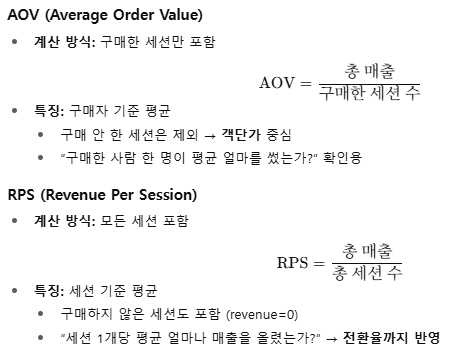

# **'부트스트랩'을 쓴 이유**

*   RPS는 '0'이 많은 분포(구매 없는 세션 등)라서 비정규+오른쪽 긴 꼬리로 형성되어있다.
*   부트스트랩은 평균의 불확실성을 분포 가정 없이 잘 잡는다.

# **정규성 검정을 수행하지 않은 이유**

*   목적은 두 그룹의 평균(AOV,RSP)의 차이가 정말 있는지 검정
*   중심 극한 정리에 의해 표본이 충분히 크면 평균의 분포는 정규에 가까워짐



# **Welch t-test를 사용한 이유**
*   Levene 등으로 먼저 등분산을 검정한 뒤 Student/Welch를 고르는 2단계 절차는 전체 1종 오류율을 부풀릴 수 있어
*   분산이 다르거나 표본 크기가 다를 때 Student t-검정은 α를 잘 지키지 못하는 반면, Welch는 α를 잘 지킴

# **AOV ,RPS 시각화**

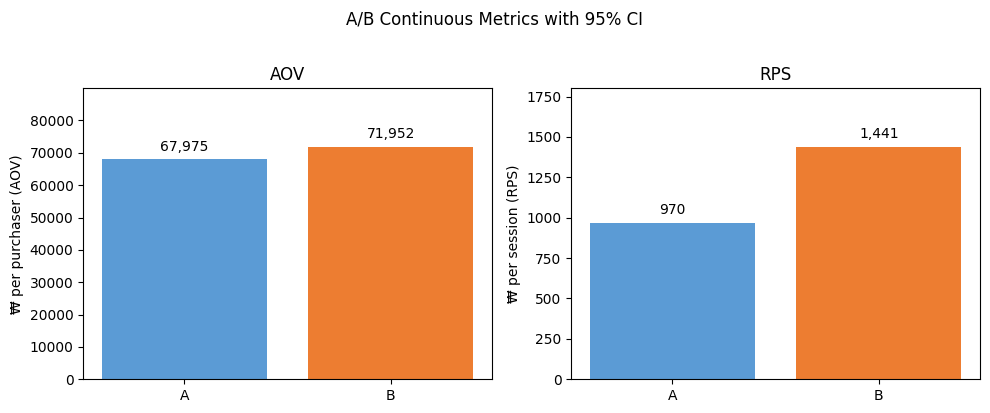

In [65]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metric_bar(ax, rep, ylabel="Revenue"):

    means = [rep["A"], rep["B"]]

    bars = ax.bar(["A","B"], means, capsize=6,
                  color=["#5B9BD5", "#ED7D31"])
    ax.set_title(rep["metric"])
    ax.set_ylabel(ylabel)
    ax.set_ylim(0, max(means)*1.25)

    # 막대 위 값 표시(천 단위 구분)
    for b, m in zip(bars, means):
        ax.annotate(f"{m:,.0f}",
                    xy=(b.get_x()+b.get_width()/2, m),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha="center", va="bottom")

# === 개별 플롯: AOV, RPS 따로 ===
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
plot_metric_bar(axes[0], rep_aov, ylabel="₩ per purchaser (AOV)")
plot_metric_bar(axes[1], rep_rps, ylabel="₩ per session (RPS)")

fig.suptitle("A/B Continuous Metrics with 95% CI", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


# 결과 테이블 + 다중검정 보정

#다중 검정을 하는 이유 - A/B 테스트에서 여러 지표(CVR, CTR, Bounce, AOV, RPS 등)를 동시에 검정하면 우연히 유의하게 나올 가능성(1종 오류)이 커짐 - Holm - Bonferroni

**why? 6개 지표 → 최소 1개 지표가 우연히 유의하게 나올 확률 ≈ 1 – (1-0.05)^6 ≈ 0.265 → 26.5%**

따라서 작은 p-value 부터 조정된 유의수준과 비교해야된다.

# *Holm-Bonferroni로 FWER 5%를 보장*
**결과 CTR, CVR, Bounce, AOV, RPS는 보정 후에도 유의했고, 결제이탈은 유의하지 않았d음**

In [68]:
import pandas as pd
from statsmodels.stats.multitest import multipletests

# 🚩 원표 생성
report = pd.DataFrame([rep_ctr, rep_cvr, rep_bounce, rep_abandon, rep_aov, rep_rps])

# 🚩 Holm 보정 p값 추가
pvals = report['p_value'].fillna(1.0).values
rej, p_holm, _, _ = multipletests(pvals, alpha=0.05, method='holm')
report['p_holm'] = p_holm
report['significant(holm)'] = rej

# 🚩 지표 타입 분리
rate_metrics = ['CTR','CVR','Bounce','Payment Abandon']
cont_metrics = ['AOV','RPS']

rates = report[report['metric'].isin(rate_metrics)].copy()
conts = report[report['metric'].isin(cont_metrics)].copy()

# 🚩 포맷 함수
fmt_pct = lambda x: f"{x:.2%}"
fmt_p   = lambda x: "p<0.001" if x<0.001 else f"{x:.4f}"
fmt_won = lambda x: f"{x:,.0f}원"

# 🚩 비율 지표 포맷
for col in ['A','A_CI_low','A_CI_high','B','B_CI_low','B_CI_high','diff(B-A)','rel_lift']:
    rates[col] = rates[col].map(fmt_pct)
rates['p_value'] = rates['p_value'].map(fmt_p)
rates['p_holm']  = rates['p_holm'].map(fmt_p)

# 🚩 연속 지표 포맷 (원화, 쉼표)
for col in ['A','A_CI_low','A_CI_high','B','B_CI_low','B_CI_high','diff(B-A)']:
    conts[col] = conts[col].map(fmt_won)
# 상대리프트는 %가 더 직관적
conts['rel_lift'] = conts['rel_lift'].map(fmt_pct)
conts['p_value']  = conts['p_value'].map(fmt_p)
conts['p_holm']   = conts['p_holm'].map(fmt_p)

# 🚩 보기 좋게 열 순서 통일
cols = ["metric","A","A_CI_low","A_CI_high","B","B_CI_low","B_CI_high",
        "diff(B-A)","rel_lift","p_value","p_holm","significant(holm)"]
rates = rates[cols].reset_index(drop=True)
conts = conts[cols].reset_index(drop=True)

print("비율 지표 (Holm 보정 포함)")
print(rates.to_string(index=False))

print("\n연속 지표 (Holm 보정 포함) ")
print(conts.to_string(index=False))


비율 지표 (Holm 보정 포함)
         metric      A A_CI_low A_CI_high      B B_CI_low B_CI_high diff(B-A) rel_lift p_value  p_holm  significant(holm)
            CTR  9.85%    9.59%    10.12% 17.60%   17.27%    17.94%     7.75%   78.67% p<0.001 p<0.001               True
            CVR  1.43%    1.33%     1.53%  2.00%    1.88%     2.13%     0.58%   40.31% p<0.001 p<0.001               True
         Bounce 34.91%   34.49%    35.33% 28.89%   28.50%    29.29%    -6.01%  -17.22% p<0.001 p<0.001               True
Payment Abandon  0.44%    0.38%     0.50%  0.52%    0.46%     0.58%     0.08%   17.81%  0.0734  0.0734              False

연속 지표 (Holm 보정 포함) 
metric       A A_CI_low A_CI_high       B B_CI_low B_CI_high diff(B-A) rel_lift p_value  p_holm  significant(holm)
   AOV 67,975원  66,817원   69,088원 71,952원  71,045원   72,874원    3,977원    5.85% p<0.001 p<0.001               True
   RPS    970원     898원    1,043원  1,441원   1,353원    1,532원      471원   48.52% p<0.001 p<0.001               True


# **결론**
# **핵심 성과(비율 지표)**

CTR: +7.75%p (상대 +78.7%), p < 0.001（Holm 보정 후에도 유의）

CVR: +0.58%p (상대 +40.3%), p < 0.001（보정 후 유의）

Bounce: −6.01%p (상대 −17.2%), p < 0.001（보정 후 유의）

Payment Abandon: +0.08%p (상대 +17.8%), p = 0.073 → 유의하지 않음（보정 후 비유의）

# **연속형 지표**

AOV(구매자 평균금액): +3,977원 (상대 +5.85%), p ≈ 1.08e−07 → 유의

RPS(세션당 매출): +470.6원 (상대 +48.5%), p ≈ 1.76e−15 → 매우 유의


 B는 유입→클릭→구매까지 전환 퍼널 전반을 개선했고, 그 결과 세션 효율(RPS) 이 크게 상승. 결제 단계 이탈률은 통계적으로 차이 없음.

 세션당 매출(RPS)과 퍼널 핵심 지표가 모두 유의하게 개선되었고(보정 후에도), 결제 이탈은 유의한 악화가 아니라고 판단. 다만 롤아웃은 단계적으로 진행하며 결제·CS 가드레일을 병행 모니터링해야할 필요가 있음

# 샘플사이즈/파워(예: CVR 2.5%→3.1% 검출, α=0.05, power=0.8)

In [62]:
from statsmodels.stats.power import NormalIndPower
power = NormalIndPower()
baseline = A['cvr']          # 예: 0.025
target   = B['cvr']          # 예: 0.031 (또는 baseline*(1+MDE))
effect   = target - baseline
p_pool   = (baseline + target)/2
sd = np.sqrt(2*p_pool*(1-p_pool))

# 그룹당 필요 n (대략치)
n_per_group = power.solve_power(effect_size=effect/sd, power=0.8, alpha=0.05, ratio=1.0, alternative='two-sided')
print(f"권장 샘플사이즈(그룹당): {int(np.ceil(n_per_group))}")


권장 샘플사이즈(그룹당): 15991


# 균형성/무작위성 점검(예:디바이스)

A/B 그룹이 디바이스 측면에서 균형 잡혀 있음

In [63]:
cont = pd.crosstab(df['user_group'], df['device'])
chi2, p_device, dof, exp = stats.chi2_contingency(cont)
print("Device balance p-value:", p_device)


Device balance p-value: 0.7048662371963732
